In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
dir = Path('E:/SHALI IMPLEMENTATION/2022/trupti/New folder/ECG_Image_data/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
1,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
2,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
3,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
4,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
...,...,...
99193,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
99194,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
99195,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
99196,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V


In [3]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [4]:
dir = Path('E:/SHALI IMPLEMENTATION/2022/trupti/New folder/ECG_Image_data/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
1,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
2,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
3,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
4,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,F
...,...,...
24794,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
24795,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
24796,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V
24797,E:\SHALI IMPLEMENTATION\2022\trupti\New folder...,V


In [5]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    validation_split=0.2
  
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [7]:
size=224
color_mode='rgb'
batch_size=32
train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):


    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

pretrained_model = VGG16(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import keras
model = keras.models.Sequential([#bulid nn
            keras.layers.Conv2D(200,kernel_size=(3,3),activation='Mish',input_shape=(224,224,3)),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2D(150,kernel_size=(3,3),activation='Mish'),
            keras.layers.BatchNormalization(),

            keras.layers.MaxPool2D(4,4),
            keras.layers.Conv2D(120,kernel_size=(3,3),activation='Mish'),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2D(80,kernel_size=(3,3),activation='Mish'),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2D(50,kernel_size=(3,3),activation='Mish'),
            keras.layers.MaxPool2D(4,4),
    
            keras.layers.Conv2D(150,kernel_size=(3,3),activation='Mish'),
            keras.layers.MaxPool2D(4,4),

            keras.layers.Flatten(),  
            keras.layers.Dense(120,activation='Mish') ,  
            keras.layers.Dense(100,activation='Mish') ,
            keras.layers.Dense(50,activation='Mish') ,       
            keras.layers.Dropout(rate=0.5) , 
            keras.layers.Dense(6,activation='softmax') ,  
        ])
Model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='Mish'),
                        Dense(64, activation='Mish'),
                        Dense(6, activation='softmax')
                    ])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 200)     5600      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 200)    800       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 150)     270150    
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 150)    600       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 150)      0         
 )                                                               
                                                        

In [12]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
Model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

result=Model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[checkpoint]
)

Epoch 1/5
96/96 [==============================] - ETA: 0s - loss: 1.1692 - accuracy: 0.6172 - precision: 0.9827 - recall: 0.2581 - auc: 0.8876
Epoch 1: val_accuracy improved from -inf to 0.97266, saving model to best_model.h5
96/96 [==============================] - 604s 6s/step - loss: 1.1692 - accuracy: 0.6172 - precision: 0.9827 - recall: 0.2581 - auc: 0.8876 - val_loss: 0.3012 - val_accuracy: 0.9727 - val_precision: 0.9885 - val_recall: 0.8945 - val_auc: 0.9986
Epoch 2/5
96/96 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9430 - precision: 0.9652 - recall: 0.9124 - auc: 0.9968
Epoch 2: val_accuracy improved from 0.97266 to 0.98307, saving model to best_model.h5
96/96 [==============================] - 510s 5s/step - loss: 0.2381 - accuracy: 0.9430 - precision: 0.9652 - recall: 0.9124 - auc: 0.9968 - val_loss: 0.0898 - val_accuracy: 0.9831 - val_precision: 0.9868 - val_recall: 0.9714 - val_auc: 0.9996
Epoch 3/5
96/96 [==============================] - ETA:

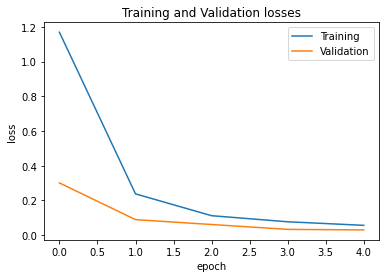

In [13]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

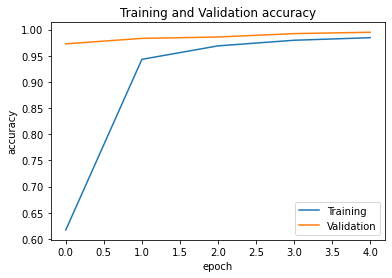

In [14]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [15]:
y_pred = Model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)

report = classification_report(test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)


30/30 [==============================] - 140s 5s/step
[[160   0   0   0   0   0]
 [  0 160   0   0   0   0]
 [  0   0 160   0   0   0]
 [  0   0   0 155   1   4]
 [  0   0   0   0 160   0]
 [  0   0   0   0   0 160]]
              precision    recall  f1-score   support

           F     1.0000    1.0000    1.0000       160
           M     1.0000    1.0000    1.0000       160
           N     1.0000    1.0000    1.0000       160
           Q     1.0000    0.9688    0.9841       160
           S     0.9938    1.0000    0.9969       160
           V     0.9756    1.0000    0.9877       160

    accuracy                         0.9948       960
   macro avg     0.9949    0.9948    0.9948       960
weighted avg     0.9949    0.9948    0.9948       960



In [30]:
path=dataframe_test['Filepath']

In [31]:
im_path=3

In [32]:
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import cv2
import pywt
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
path_im=path[im_path]
testImageData = cv2.imread(path_im)
from pathlib import Path
# testImageDataFeature = image_resize(testImageData)/255.0
# testImageDataFeature = np.array([testImageDataFeature])

In [33]:
path_im

'E:\\SHALI IMPLEMENTATION\\2022\\trupti\\New folder\\ECG_Image_data\\test\\Q\\Q883.png'

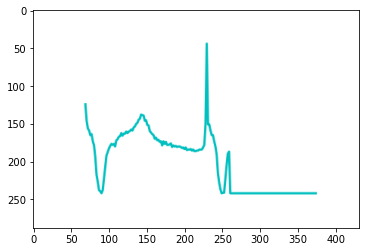

In [34]:
plt.imshow(testImageData)

(-0.5, 431.5, 287.5, -0.5)

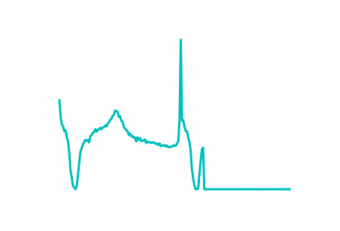

In [35]:
sigma = 0.005

noisy = random_noise(testImageData, var=sigma**2)
#plt.title('Noisy Image',fontsize=15)
plt.imshow(noisy);
plt.axis('off')

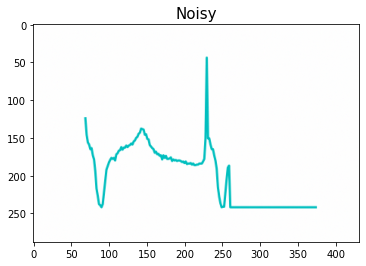

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


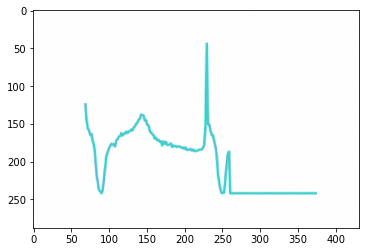

<Figure size 432x288 with 0 Axes>

In [36]:
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)

im_bayes = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)


LL, (LH, HL, HH) = pywt.dwt2(noisy, 'haar')

titles = ['noisy', 'denoised']
denoised = pywt.idwt2((LL, (LH, HL, None)), 'haar')
plt.imshow(noisy)

plt.title('Noisy',fontsize=15)
plt.show()
plt.imshow(denoised)
plt.title('',fontsize=15)
plt.show()
# plt.savefig('E:/SHALI IMPLEMENTATION/2022/trupti/ECG_Image_data/a2.png')

In [46]:
reverse_mapping = ['F', 'M', 'N', 'Q', 'S', 'V']
prediction_name = reverse_mapping[int(y_pred[3])]
print(prediction_name)

Q


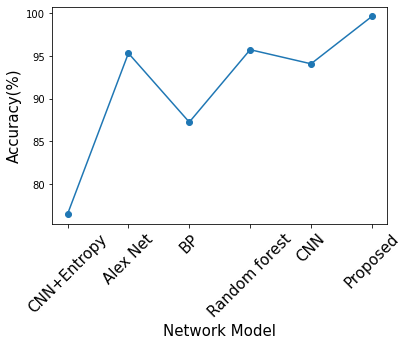

In [25]:
#####comparision
import matplotlib.pyplot as plt
import numpy as np
plt.figure(1)
r=[1,2,3,4,5,6]
rm=[76.5,95.31,87.25,95.72,94.07,99.61]
labels = ['CNN+Entropy','Alex Net','BP','Random forest','CNN','Proposed']
plt.plot(r, rm,marker = 'o')
plt.xlabel("Network Model",fontsize = 15)
plt.ylabel("Accuracy(%)",fontsize = 15)

plt.xticks(r, labels ,fontsize = 15,rotation =45)
plt.show()

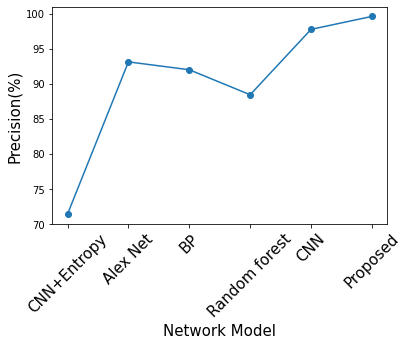

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(1)
r=[1,2,3,4,5,6]
rm=[71.4,93.12,92,88.43,97.76,99.61]
labels = ['CNN+Entropy','Alex Net','BP','Random forest','CNN','Proposed']
plt.plot(r, rm,marker = 'o')
plt.xlabel("Network Model",fontsize = 15)
plt.ylabel("Precision(%)",fontsize = 15)

plt.xticks(r, labels ,fontsize = 15,rotation =45)
plt.show()

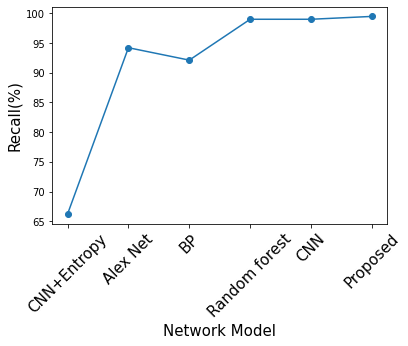

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(1)
r=[1,2,3,4,5,6]
rm=[66.2,94.21,92.12,99,99,99.48]
labels = ['CNN+Entropy','Alex Net','BP','Random forest','CNN','Proposed']
plt.plot(r, rm,marker = 'o')
plt.xlabel("Network Model",fontsize = 15)
plt.ylabel("Recall(%)",fontsize = 15)

plt.xticks(r, labels ,fontsize = 15,rotation =45)
plt.show()

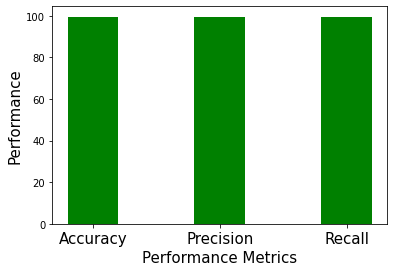

In [28]:
m=[1,2,3]
n=[99.61,99.61,99.48]

plt.bar(m,n,color='g',width = 0.4)
plt.xlabel("",fontsize = 15)
plt.xticks(m,['Accuracy', 'Precision', 'Recall'],fontsize = 15)
#plt.xticks(rotation=45) 
plt.xlabel("Performance Metrics",fontsize = 15)

plt.ylabel("Performance",fontsize = 15)
plt.show()

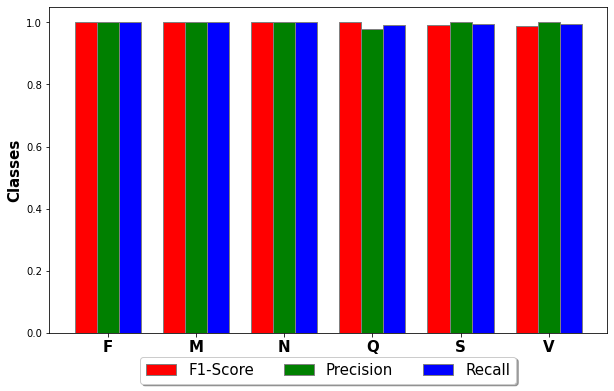

In [29]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6))
 
# set height of bar
f1 = [1,1,1,1,0.993,0.987]
pre = [1,1,1,0.98,1,1]
rec = [1,1,1,0.99,0.996,0.9951]
 
# Set position of bar on X axis
br1 = np.arange(len(f1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1, color ='r', width = barWidth,
        edgecolor ='grey', label ='F1-Score')
plt.bar(br2, pre, color ='g', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, rec, color ='b', width = barWidth,
        edgecolor ='grey', label ='Recall')
 
# Adding Xticks
plt.xlabel('Preformance(%)', fontweight ='bold', fontsize = 15)
plt.ylabel('Classes', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(f1))],
        ['F', 'M', 'N', 'Q', 'S','V'], fontweight ='bold', fontsize = 15)
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,fontsize = 15)
plt.show()